In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

The dataset can be accessed via the last link on our proposal.

In [2]:
datapath = 'Fantasy-Premier-League-master/data/2022-23/'

### Preprocessing

1. gw_df
- Gameweek data. The 'merged_gw.csv' combines all 38 gameweeks at the player-gameweek level.
- 'name', 'team', 'opponent_team', 'fixture' kept for joining with other tables
- 'minutes' kept for filtering out rows where the player did not play that week
- ict kept to be aggregated into additional features
- __'total_points' is the target variable for prediction__ in this baseline model. In other words, we are making gameweek-by-gameweek points scored by players. 

2. team_df
- mainly for retrieving team ids and joining

3. fixture_df
- mainly for calculating matchup difficulty as an additional feature

In [3]:
fixture_df = pd.read_csv(datapath+'fixtures.csv')
team_df = pd.read_csv(datapath+'teams.csv')
gw_df = pd.read_csv(datapath+'gws/merged_gw.csv')

In [4]:
gw_df = gw_df[['name', 'team', 'minutes', 'creativity', 'fixture', 'influence', 'opponent_team',
       'threat', 'total_points', 'was_home', 'GW']]
team_df = team_df[['id', 'name']]
fixture_df = fixture_df[['event', 'id', 'team_a', 'team_h', 'team_h_difficulty', 'team_a_difficulty']]

In [5]:
# Removing player-gameweek rows where the player is not playing that week
gw_df = gw_df.drop(gw_df[gw_df.minutes==0].index)

In [6]:
# Joining (merging) tables
gw_df = gw_df.merge(team_df, left_on='team', right_on='name').rename(columns={'id':'player_team'}).drop(columns={'team', 'name_y'})
gw_df = gw_df.merge(fixture_df, left_on='fixture', right_on='id')
gw_df.head()

,name_x,minutes,creativity,fixture,influence,opponent_team,threat,total_points,was_home,GW,player_team,event,id,team_a,team_h,team_h_difficulty,team_a_difficulty
0,Nathan Redmond,1,0.0,8,0.0,18,0.0,1,False,1,17,1,8,17,18,2,4
1,Roméo Lavia,90,4.3,8,12.0,18,8.0,2,False,1,17,1,8,17,18,2,4
2,Joe Ayodele-Aribo,90,5.2,8,9.4,18,23.0,2,False,1,17,1,8,17,18,2,4
3,Stuart Armstrong,45,2.6,8,3.4,18,0.0,1,False,1,17,1,8,17,18,2,4
4,Oriol Romeu Vidal,74,3.8,8,6.2,18,2.0,2,False,1,17,1,8,17,18,2,4


Generating Additional Features
1. __get_difficulty_gap()__:
Note that in the merged table above, 'player_team' and 'opponent_team' can be matched with 'team_a' and 'team_h'.
Then we may calculate the difficulty gap (player team's difficulty - opponent team's difficulty) as a measure of difference in team strength.

2. __get_prev_stats()__:
Because the ICT index is synthesized *after* the gameweek's results are settled, when we don't know the 'total_points' of a given player in a given gameweek, we also don't know the ICT index. 
Although we cannot use them directly for prediction, we can aggregate previous gameweeks' ICT index, which are known to us, as features. The same logic applies to previous weeks' total points.

In [7]:
def get_difficulty_gap(row):
    if row.player_team == row.team_h:
        return row.team_h_difficulty - row.team_a_difficulty
    else:
        return row.team_a_difficulty - row.team_h_difficulty

# Averaging the ICT and total_points of the previous 5 gameweeks. 
# Tentative design choice: for the baseline model, we ignore the first 5 gameweeks when training and predicting.
def get_prev_stats(row):
    history = 5
    if row.GW <= history:
        return -1, -1, -1, -1
    player_history = gw_df[(gw_df.name_x == row.name_x) & ((gw_df.GW >= row.GW - history) & (gw_df.GW < row.GW))]
    return player_history.creativity.mean(), player_history.influence.mean(), player_history.threat.mean(), player_history.total_points.mean()

In [8]:
# Append historical ICT and total_points feature to the main gw_df.
# Tentative design choice: in rare cases where a player did not play in previous 5 weeks and plays in the 6th
# -- we fill the nan resulted from the mean calculation with 0 for now.
prev_stats = gw_df.apply(get_prev_stats, axis=1, result_type='expand').rename(columns={0:'prev_avg_c', 1:'prev_avg_i', 2:'prev_avg_t', 3:'prev_avg_score'})
prev_stats.fillna(0, inplace=True)
gw_df = pd.concat([gw_df, prev_stats], axis=1)

In [9]:
# Append the difficulty gap feature to the main gw_df
gw_df['difficulty_gap'] = gw_df.apply(get_difficulty_gap, axis=1)

In [10]:
# Final adjustments, selecting columns, applying one-hot encoding to categoricals
gw_df = gw_df[['was_home', 'GW',
       'prev_avg_score', 'prev_avg_c', 'prev_avg_i', 'prev_avg_t', 'difficulty_gap', 'total_points']]

gw_df = gw_df[gw_df.GW > 5]
gw_df = pd.get_dummies(gw_df)

In [11]:
gw_df.head(-5)

,was_home,GW,prev_avg_score,prev_avg_c,prev_avg_i,prev_avg_t,difficulty_gap,total_points
148,False,6,4.500000,16.300000,21.150000,29.250000,0,2
149,False,6,2.600000,4.820000,13.120000,26.400000,0,2
150,False,6,1.250000,11.600000,4.300000,6.500000,0,1
151,False,6,0.600000,3.780000,16.760000,6.400000,0,2
152,False,6,2.000000,4.800000,8.133333,11.666667,0,1
...,...,...,...,...,...,...,...,...
11335,False,24,2.666667,29.000000,15.300000,12.833333,-2,2
11336,False,24,1.800000,8.720000,15.480000,1.800000,-2,5
11337,False,24,2.666667,17.533333,12.266667,7.500000,-2,7
11338,False,24,2.250000,7.125000,11.250000,17.500000,-2,2


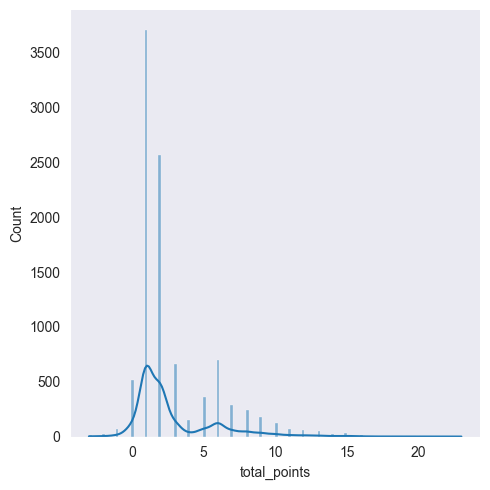

In [12]:
sns.set_style("dark")
sns.displot(data=gw_df, x="total_points", kde=True);

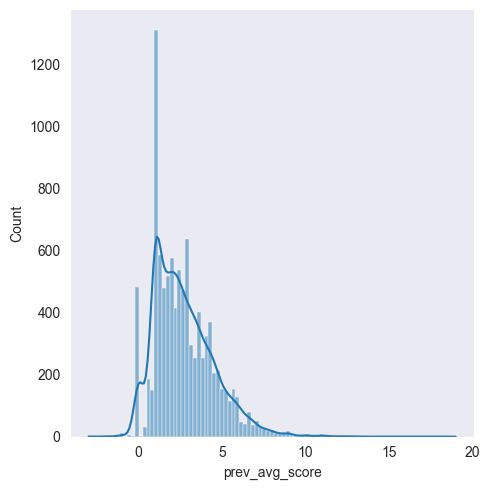

In [13]:
sns.displot(data=gw_df, x="prev_avg_score", kde=True);

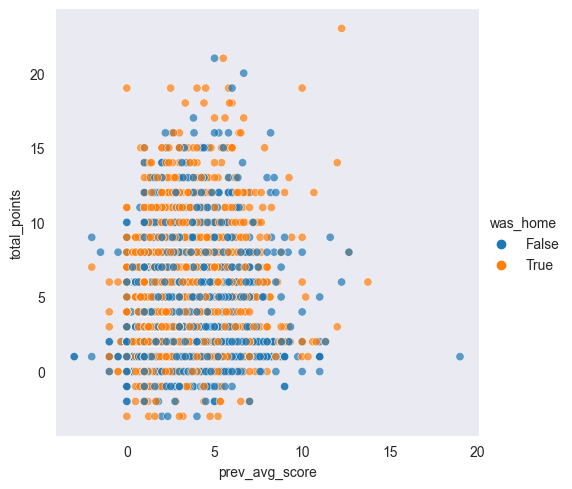

In [14]:
sns.relplot(data=gw_df, x="prev_avg_score", y="total_points", hue="was_home", alpha=0.7);

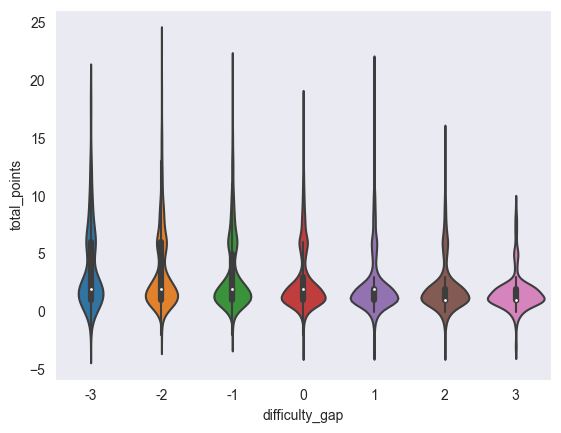

In [15]:
sns.violinplot(data=gw_df, x="difficulty_gap", y="total_points");

### Training and Evaluation

In [16]:
X = gw_df.drop('total_points', axis=1)
y = gw_df.total_points

# Train/Valid/Test 0.6/0.2/0.2
# Test set is still held-out and won't be used until writing the report.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [17]:
# Ridge, Lasso, ElasticNet pretty similar in terms of mse
clf = linear_model.Ridge(alpha=1)
clf.fit(X_train, y_train)
preds = clf.predict(X_val)

In [18]:
train_preds = clf.predict(X_train)
mean_squared_error(y_train, train_preds)

7.874080167006342

__MSE with predictions from the linear model__ (model)

In [19]:
mean_squared_error(y_val, preds)

7.7263900411353355

__MSE with the heuristic of simply using previous 5 weeks' average points__ (baseline)

In [20]:
mean_squared_error(y_val, X_val.prev_avg_score)

9.785669545624158

Model Coefficients

In [21]:
pd.DataFrame([clf.feature_names_in_, clf.coef_])

,0,1,2,3,4,5,6
0,was_home,GW,prev_avg_score,prev_avg_c,prev_avg_i,prev_avg_t,difficulty_gap
1,0.30266,0.002219,0.111143,0.014596,0.030823,0.019604,-0.302588


### What's Next
1. More years of data
2. Target Variable:
    While we still want to predict player points, we can explore if its more reasonable to
    predict week-by-week or for the average of the next 3 or 5 weeks 
3. Fixture Difficulty & Position:
    Currently the dataset only provides difficulty on an integer scale of 2 to 5, which is pretty coarse.
    With position data and team composition data available, we can narrow down the measurement of
    difficulty (e.g. DEF vs. oppo FWD, FWD vs. oppo DEF, MID vs. oppo all) and represent it in terms
    of the opponents' recent/historical performance.
4. Other traditional machine learning methods